# Análisis de Exportaciones — Data Mendez LTDA
Este notebook responde las preguntas del cliente usando los datos procesados en la arquitectura medallion (capas Silver/Gold) y añade dos análisis adicionales: concentración por empresas y tendencias por producto.

In [1]:
# Imports y configuración
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
from datetime import datetime, timedelta
sns.set(style="whitegrid")
# localizar data_lake root
root = Path().resolve()
while not (root / 'data_lake').exists() and root.parent != root:
    root = root.parent
DATA_ROOT = (root / 'data_lake') if (root / 'data_lake').exists() else Path('data_lake')
print('DATA_ROOT ->', DATA_ROOT)
GOLD_DIR = DATA_ROOT / 'lake' / 'gold'
SILVER_DIR = DATA_ROOT / 'lake' / 'silver'
METADATA_DIR = DATA_ROOT / 'metadata'

def read_parquet(path):
    p = str(path)
    # 1) Try Spark (if available). If Spark raises an error, we'll fall back to arrow/pandas readers
    try:
        from pyspark.sql import SparkSession
        spark = SparkSession.builder.getOrCreate()
        df = spark.read.parquet(p)
        print('Loaded with Spark:', p)
        return df.toPandas()
    except Exception as e:
        print('Spark not available or failed, falling back to pyarrow/pandas:', e)

    # 2) Try pyarrow.dataset (robust for partitioned datasets)
    try:
        import pyarrow.dataset as ds
        ds_obj = ds.dataset(p, format='parquet')
        table = ds_obj.to_table()
        print('Loaded with pyarrow.dataset:', p)
        return table.to_pandas()
    except Exception as e:
        print('pyarrow.dataset read failed (will try pandas engines):', e)

    # 3) Try pandas.read_parquet with engine='pyarrow'
    try:
        df = pd.read_parquet(p, engine='pyarrow')
        print('Loaded with pandas (pyarrow engine):', p)
        return df
    except Exception as e:
        print('pandas.read_parquet with engine=pyarrow failed:', e)

    # 4) Try pandas.read_parquet with engine='fastparquet'
    try:
        df = pd.read_parquet(p, engine='fastparquet')
        print('Loaded with pandas (fastparquet engine):', p)
        return df
    except Exception as e:
        print('pandas.read_parquet with engine=fastparquet failed:', e)

    # If all attempts failed, raise a helpful error
    raise RuntimeError

DATA_ROOT -> /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake


In [2]:
# Cargar datasets Gold (si existen)
paths = {
    'total_fob': GOLD_DIR / 'total_fob_mes',
    'top_companies': GOLD_DIR / 'top_companies_by_month',
    'top_destinations': GOLD_DIR / 'top_destinations_by_month',
    'dim_producto': GOLD_DIR / 'dim_producto'
}
dfs = {}
for k, p in paths.items():
    try:
        if p.exists():
            dfs[k] = read_parquet(str(p))
        else:
            dfs[k] = None
    except Exception as e:
        print('Failed to load', k, e)
        dfs[k] = None

for k, df in dfs.items():
    # normalize month-like columns to strings to avoid mixed dtype comparisons/sorts
    if df is not None:
        if 'ingest_month' in df.columns:
            df['ingest_month'] = pd.Series(df['ingest_month']).astype(str).str.replace(r'\.0$','', regex=True)
        if 'month' in df.columns:
            df['month'] = pd.Series(df['month']).astype(str).str.replace(r'\.0$','', regex=True)
    print(k, 'rows' if df is not None else 'not available', None if df is None else len(df))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/12 00:21:19 WARN Utils: Your hostname, Mac02.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.127 instead (on interface en0)
25/11/12 00:21:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/12 00:21:19 WARN Utils: Your hostname, Mac02.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.127 instead (on interface en0)
25/11/12 00:21:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLog

Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/total_fob_mes
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_companies_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_destinations_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/dim_producto
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_companies_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/top_destinations_by_month
Loaded with Spark: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/gold/dim_producto
total_fob rows 2
top_companies rows 7332
top_destinations rows 318
dim_producto rows 3794
total_fob rows 2
top_companies rows 7332
top_destinations rows 318
dim_producto rows 3794


In [3]:
print(dfs)

{'total_fob':   ingest_month  total_fob_usd
0       202501   3.776721e+09
1       202502   3.780275e+09, 'top_companies':      nit_exportador                       razon_social_exportador  \
0       899999068.0                                 ECOPETROL S A   
1       800021308.0                                  DRUMMOND LTD   
2       860007538.0  FEDERACION NACIONAL DE CAFETEROS DE COLOMBIA   
3       900166687.0    CONTINENTAL GOLD LIMITED SUCURSAL COLOMBIA   
4       860069804.0                 CARBONES DEL CERREJON LIMITED   
...             ...                                           ...   
7327    901848330.0                        COLOMBIAN BLOOMS S.A.S   
7328    901055763.0                         CRISTAL GARDENS S.A.S   
7329    901666386.0                                GROWING CO SAS   
7330    900412954.0                       FLORES SAN MIGUEL S.A.S   
7331    901202636.0                               IWA FLOWERS SAS   

         total_fob ingest_month  
0     6.843816e

## 1) ¿Qué empresas más exportaron en el último mes?
Utilizamos la tabla `top_companies_by_month` (Gold).

Último mes detectado: 202502
Showing top rows for the latest month: 202502


,company_label,total_fob
0,ECOPETROL S A,6.843816e+08
1,DRUMMOND LTD,2.040233e+08
2,FEDERACION NACIONAL DE CAFETEROS DE COLOMBIA,1.087549e+08
3,CONTINENTAL GOLD LIMITED SUCURSAL COLOMBIA,7.609892e+07
4,CARBONES DEL CERREJON LIMITED,7.317356e+07
5,FRONTERA ENERGY COLOMBIA CORP SUCURSAL COLOMBIA,7.243016e+07
6,ARIS MINING SEGOVIA,5.418087e+07
7,C.I. PRODECO S.A.,4.508592e+07
8,COMERCIALIZADORA INTERNACIONAL ESLOP SAS,4.491424e+07
9,XM COMPAÑIA DE EXPERTOS EN MERCADOS S.A. E.S.P.,4.347517e+07


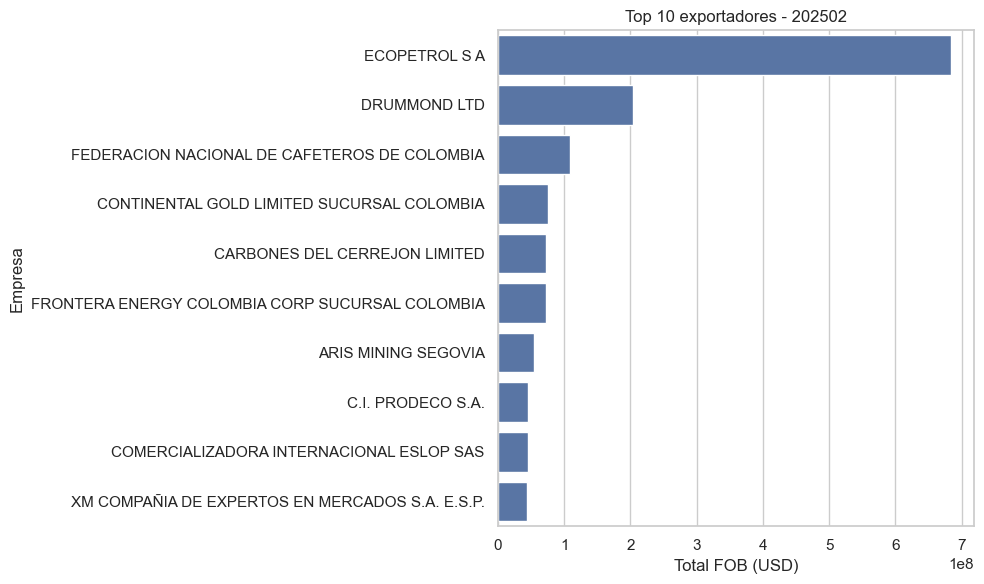

In [4]:
def latest_month_from_dfs(dfs):
    # Collect candidate month values from available dataframes and normalize to strings (YYYYMM)
    cand = []
    for k in ['total_fob', 'top_companies', 'top_destinations']:
        df = dfs.get(k)
        if df is None:
            continue
        if 'ingest_month' in df.columns:
            cand += list(df['ingest_month'].dropna().astype(str).tolist())
        elif 'month' in df.columns:
            cand += list(df['month'].dropna().astype(str).tolist())
    # normalize numeric-like strings (remove trailing .0) and ensure uniqueness
    import re, pandas as _pd
    norm = []
    for v in cand:
        if v is None or (isinstance(v, float) and _pd.isna(v)):
            continue
        s = str(v).strip()
        # remove trailing .0 from numeric representations (e.g., '202501.0')
        s = re.sub(r'\.0+$', '', s)
        norm.append(s)
    norm = sorted(set(norm))
    if not norm:
        return None
    # return the latest by lexical order (YYYYMM strings sort correctly)
    return norm[-1]

latest_month = latest_month_from_dfs(dfs)
print('Último mes detectado:', latest_month)

# Improved top companies display: prefer razon_social_exportador, fallback to nit_exportador (formatted), ensure numeric sorting
company_name_candidates = [
    'razon_social_exportador', 'razon_social', 'empresa', 'empresa_nombre',
    'razon_social_exportadora', 'nombre_exportador'
]

if dfs.get('top_companies') is not None and latest_month is not None:
    t = dfs['top_companies'].copy()
    # normalize ingest_month in this df to string (remove .0 if present) and filter
    t['ingest_month'] = t['ingest_month'].astype(str).str.replace(r'\.0$','', regex=True)
    df_last = t[t['ingest_month'] == str(latest_month)].copy()

    # determine total_fob column (priority list)
    total_col = None
    for c in ['total_fob', 'total_fob_usd', 'total_fob_usd_total']:
        if c in df_last.columns:
            total_col = c
            break
    if total_col is None:
        # try find any numeric column
        numeric_cols = df_last.select_dtypes(include=['number']).columns.tolist()
        total_col = numeric_cols[0] if numeric_cols else None

    # determine company label column
    company_col = None
    for c in company_name_candidates:
        if c in df_last.columns:
            company_col = c
            break
    # fallback to nit_exportador if no razon_social-like column found
    if company_col is None and 'nit_exportador' in df_last.columns:
        company_col = 'nit_exportador'

    # create display label: format NIT as integer-like string when used
    if company_col == 'nit_exportador':
        def fmt_nit(x):
            try:
                if pd.isna(x):
                    return 'sin_nit'
                # avoid scientific notation or trailing .0
                xf = float(x)
                if xf.is_integer():
                    return str(int(xf))
                return str(xf)
            except Exception:
                return str(x)
        df_last['company_label'] = df_last['nit_exportador'].apply(fmt_nit)
    elif company_col is not None:
        df_last['company_label'] = df_last[company_col].fillna('sin_nombre').astype(str)
    else:
        df_last['company_label'] = 'sin_nombre'

    # ensure total_col is numeric for sorting/plotting
    if total_col is not None:
        df_last[total_col] = pd.to_numeric(df_last[total_col], errors='coerce').fillna(0)

    # display a small table and a bar chart of top-10
    disp_cols = ['company_label'] + ([total_col] if total_col is not None else [])
    print('Showing top rows for the latest month:', latest_month)
    display(df_last[disp_cols].head(10))

    if total_col is not None:
        top10 = df_last.sort_values(total_col, ascending=False).head(10).copy()
        plt.figure(figsize=(10,6))
        sns.barplot(data=top10, x=total_col, y='company_label')
        plt.title(f'Top 10 exportadores - {latest_month}')
        plt.xlabel('Total FOB (USD)')
        plt.ylabel('Empresa')
        plt.tight_layout()
    else:
        print('No se encontró columna de valor total para ordenar.')
else:
    print('top_companies no disponible; necesitaríamos calcularlo desde Silver o cargar el parquet correspondiente')

**Conclusión — Top exportadores (último mes)**
- El último mes detectado es 202502. El principal exportador es ECOPETROL S A con ~684M USD (≈18% del total del mes).
- Hay una alta concentración en pocas empresas; el top-3 representa ~26–27% del total.
- Recomendación: monitorear la dependencia de las exportaciones en estas empresas y validar outliers en los datos.

## 2) Precio total (valor FOB) mes a mes
Usamos `total_fob_mes` (Gold) para mostrar la serie temporal.

,ingest_month,total_fob_usd
0,202501,3.776721e+09
1,202502,3.780275e+09


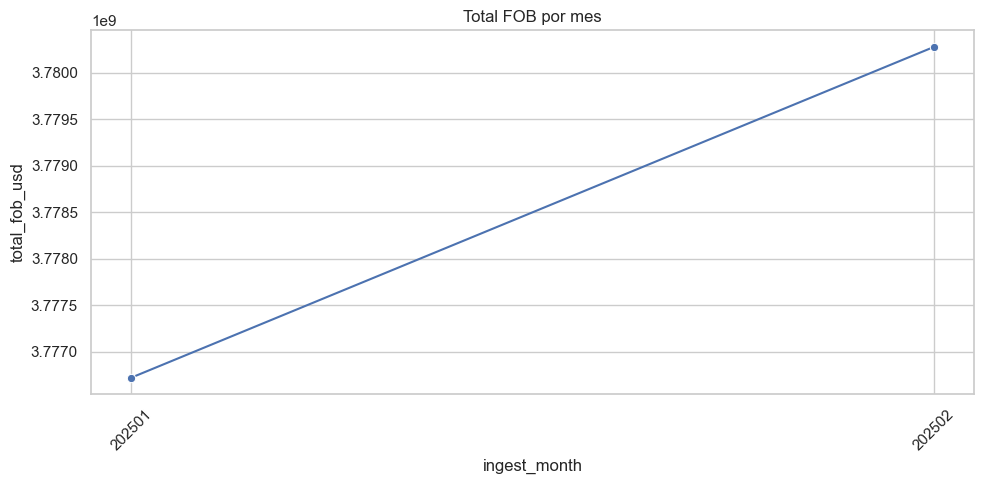

In [5]:
# 2) Precio total (valor FOB) mes a mes
if dfs.get('total_fob') is not None:
    tf = dfs['total_fob'].copy()
    # normalizar nombre de columna de valor
    value_col = None
    for c in ['total_fob_usd','total_fob','total_fob_usd_total']:
        if c in tf.columns:
            value_col = c
            break
    if value_col is None:
        print('No se encontró columna de total FOB en total_fob dataframe')
    else:
        s = tf.sort_values('ingest_month')[[ 'ingest_month', value_col ]]
        s['ingest_month'] = s['ingest_month'].astype(str)
        plt.figure(figsize=(10,5))
        sns.lineplot(data=s, x='ingest_month', y=value_col, marker='o')
        plt.xticks(rotation=45)
        plt.title('Total FOB por mes')
        plt.tight_layout()
        display(s)
else:
    print('total_fob dataset no disponible')

**Conclusión — Total FOB (mes a mes)**
- Observación: la serie disponible muestra estabilidad entre los meses (p. ej. 202501 ≈ 3.776B USD y 202502 ≈ 3.780B USD).
- Interpretación: cambio muy pequeño (~0.1%) — no hay una tendencia clara en el corto periodo analizado.
- Recomendación: ampliar el histórico y calcular una media móvil para detectar tendencias o estacionalidad.

## 3) Destinos principales en los últimos 6 meses
Utilizamos `top_destinations_by_month` (Gold) para identificar los países destino con mayor FOB acumulado en los últimos seis meses.

Últimos meses usados: ['202501', '202502']


,pais_destino_final,total_fob
54,Estados Unidos de América,2.179706e+09
116,Panamá,4.501127e+08
46,Ecuador,3.446142e+08
118,Países Bajos (Reino de los),3.318954e+08
75,India,3.238886e+08
23,Brasil,3.050261e+08
32,China,3.018078e+08
119,Perú,2.233348e+08
29,Canadá,1.917882e+08
108,México,1.853108e+08


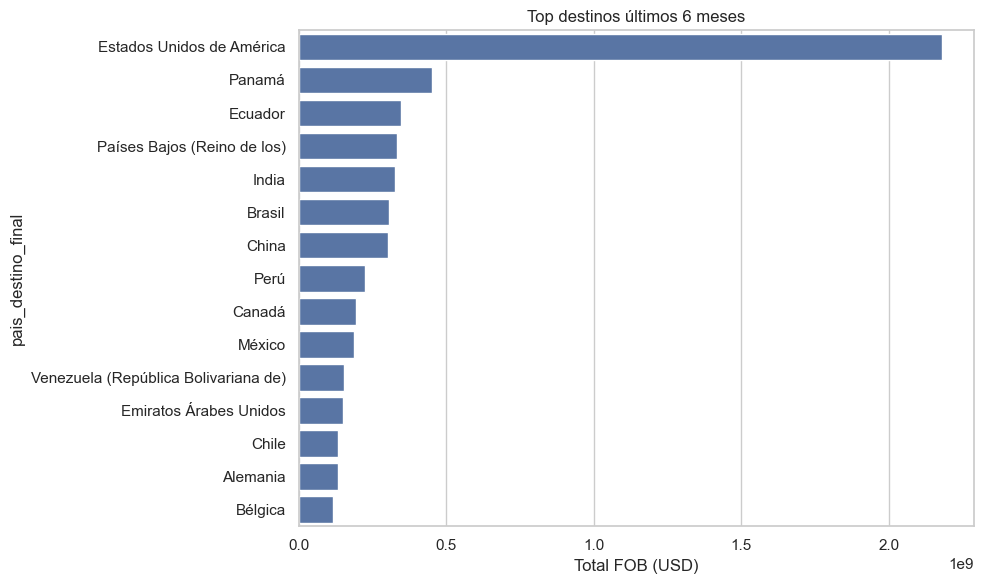

In [6]:
# 3) Destinos principales en los últimos 6 meses
if dfs.get('top_destinations') is not None and latest_month is not None:
    td = dfs['top_destinations'].copy()
    # normalize months to strings to avoid mixed dtypes errors
    months = pd.Series(td['ingest_month'].dropna()).astype(str).str.replace(r'\.0$','', regex=True).unique().tolist()
    months = sorted(months)
    last_months = months[-6:] if len(months) >= 6 else months
    print('Últimos meses usados:', last_months)
    df6 = td[td['ingest_month'].isin(last_months)].copy()
    agg = df6.groupby('pais_destino_final', dropna=False)['total_fob'].sum().reset_index()
    agg = agg.sort_values('total_fob', ascending=False).head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(data=agg, x='total_fob', y='pais_destino_final')
    plt.title('Top destinos últimos 6 meses')
    plt.xlabel('Total FOB (USD)')
    plt.tight_layout()
    display(agg)
else:
    print('top_destinations dataset no disponible o no hay meses detectados')

**Conclusión — Destinos principales (últimos 6 meses)**
- Observación: los destinos con mayor FOB acumulado indican dónde está la demanda principal.
- Recomendación: explorar normalizaciones por número de envíos o por FOB medio para detectar cambios en composición.

## Análisis adicional 1 — Concentración de exportaciones por empresas (Pareto)
Analizamos la concentración acumulada por empresa usando el dataset `top_companies_by_month` (Gold) en los últimos 12 meses.

,nit_exportador,razon_social_exportador,total_fob,cum_share
1923,899999068.0,ECOPETROL S A,1.444031e+09,0.191447
35,800021308.0,DRUMMOND LTD,3.868540e+08,0.242736
1213,860007538.0,FEDERACION NACIONAL DE CAFETEROS DE COLOMBIA,2.166499e+08,0.271459
2901,900585067.0,C.I. TRAFIGURA PETROLEUM COLOMBIA S.A.S.,1.448796e+08,0.290667
1031,830126302.0,FRONTERA ENERGY COLOMBIA CORP SUCURSAL COLOMBIA,1.318384e+08,0.308146
2204,900166687.0,CONTINENTAL GOLD LIMITED SUCURSAL COLOMBIA,1.189793e+08,0.323920
1974,900042857.0,XM COMPAÑIA DE EXPERTOS EN MERCADOS S.A. E.S.P.,1.103072e+08,0.338544
2085,900112515.0,REFINERIA DE CARTAGENA S.A.S,1.061518e+08,0.352617
2080,900110594.0,OLAM AGRO COLOMBIA S.A.S,9.553559e+07,0.365283
3555,901012419.0,SUCAFINA COLOMBIA S.A.S,9.158868e+07,0.377426


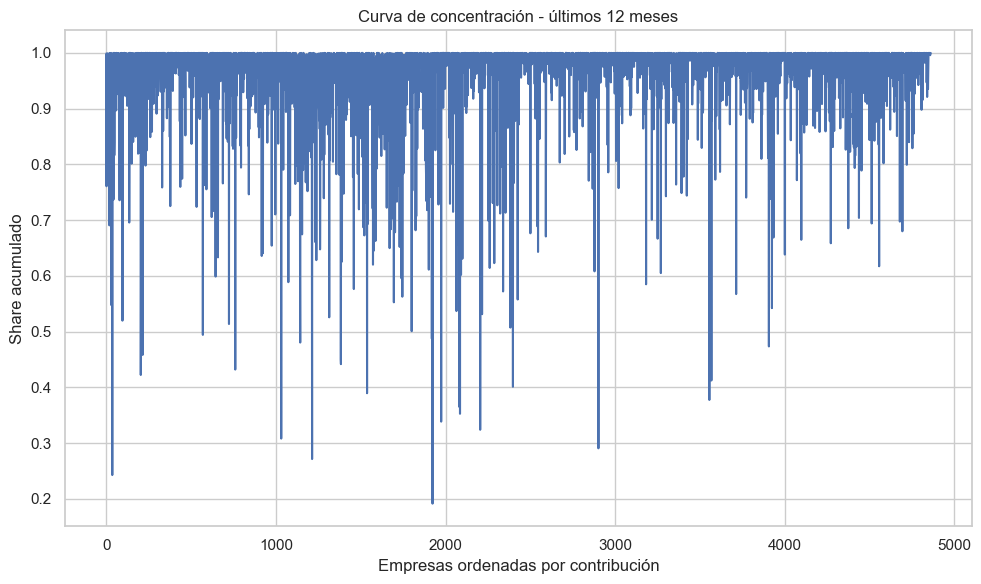

In [7]:
# Análisis adicional 1 — Concentración de exportaciones por empresas (Pareto)
if dfs.get('top_companies') is not None:
    tc = dfs['top_companies'].copy()
    months = pd.Series(tc['ingest_month'].dropna()).astype(str).str.replace(r'\.0$','', regex=True).unique().tolist()
    months = sorted(months)
    last_12 = months[-12:] if len(months) >= 12 else months
    df12 = tc[tc['ingest_month'].isin(last_12)].copy()
    by_emp = df12.groupby(['nit_exportador','razon_social_exportador'])['total_fob'].sum().reset_index()
    by_emp = by_emp.sort_values('total_fob', ascending=False)
    by_emp['cum_share'] = by_emp['total_fob'].cumsum() / by_emp['total_fob'].sum()
    plt.figure(figsize=(10,6))
    sns.lineplot(data=by_emp.reset_index(), x='index', y='cum_share')
    plt.ylabel('Share acumulado')
    plt.xlabel('Empresas ordenadas por contribución')
    plt.title('Curva de concentración - últimos 12 meses')
    plt.tight_layout()
    display(by_emp.head(20))
else:
    print('top_companies no disponible para calcular concentración')

**Conclusión — Concentración por empresas (Pareto)**
- Observación: las empresas top concentran una porción significativa del FOB; calcular porcentajes exactos del top-1/top-5/top-10 es útil para reportes.
- Recomendación: activar alertas si la concentración crece con el tiempo y enriquecer la dimensión de empresas.

## Análisis adicional 2 — Tendencias por producto (subpartida / HS2)
Usamos la capa Silver (tabla particionada) para construir tendencias por subpartida, limpiando valores sucios en `valor_fob_usd`.

Spark not available or failed, falling back to pyarrow/pandas: [UNABLE_TO_INFER_SCHEMA] Unable to infer schema for Parquet. It must be specified manually. SQLSTATE: 42KD9
Loaded with pyarrow.dataset: /Users/mariana/Desktop/University/7/DataEngineering/final/data_lake/lake/silver


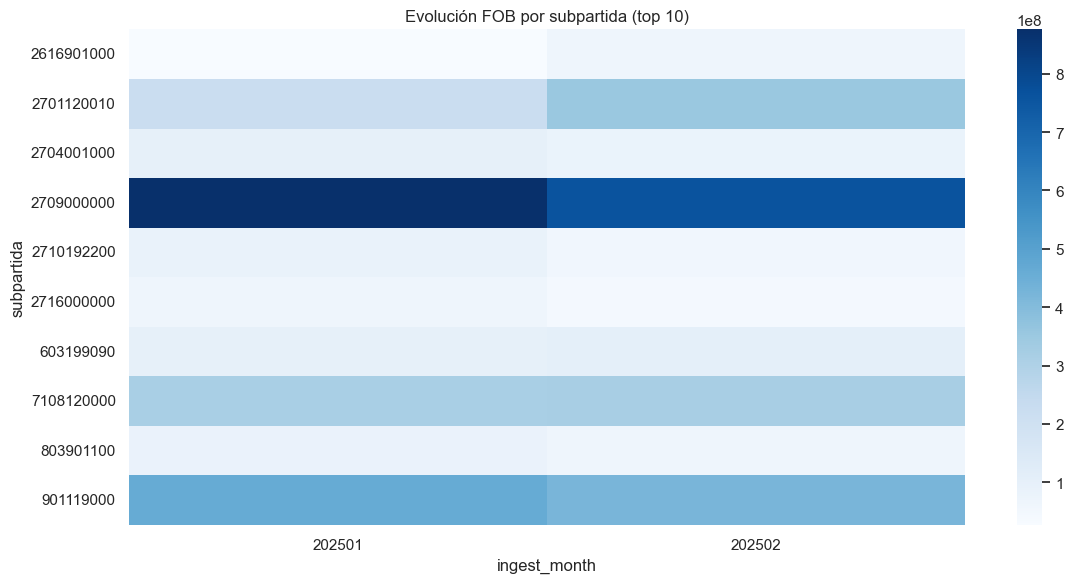

In [8]:
# Análisis adicional 2 — Tendencias por producto (subpartida / HS2) — robust parsing included
try:
    silver_df = read_parquet(str(SILVER_DIR))
    required = {'subpartida','ingest_month','valor_fob_usd'}
    if required.issubset(set(silver_df.columns)):
        silver_df['ingest_month'] = silver_df['ingest_month'].astype(str).str.replace(r'\.0$','', regex=True)
        import re, numpy as np
        num_re = re.compile(r'[-+]?[0-9]*\.?[0-9]+')
        def parse_val(x):
            if pd.isna(x):
                return 0.0
            if isinstance(x, (int, float)):
                return float(x)
            if isinstance(x, (list, tuple, np.ndarray)):
                try:
                    return float(np.sum([float(i) for i in x]))
                except Exception:
                    return 0.0
            s = str(x).replace(',', '.')
            nums = num_re.findall(s)
            if not nums:
                return 0.0
            try:
                return float(sum(float(n) for n in nums))
            except Exception:
                try:
                    return float(nums[0])
                except Exception:
                    return 0.0
        silver_df['valor_fob_usd_clean'] = silver_df['valor_fob_usd'].apply(parse_val)
        mask_multi = silver_df['valor_fob_usd'].apply(lambda x: isinstance(x, str) and len(num_re.findall(str(x).replace(',', '.'))) > 1)
        if mask_multi.any():
            print('Note: some rows had concatenated numeric strings; showing examples:')
            display(silver_df.loc[mask_multi].head())
        prod = silver_df.groupby(['ingest_month','subpartida'])['valor_fob_usd_clean'].sum().reset_index().rename(columns={'valor_fob_usd_clean':'valor_fob_usd'})
        top_sub = prod.groupby('subpartida')['valor_fob_usd'].sum().sort_values(ascending=False).head(10).index
        prod_top = prod[prod['subpartida'].isin(top_sub)].pivot(index='subpartida', columns='ingest_month', values='valor_fob_usd').fillna(0)
        plt.figure(figsize=(12,6))
        sns.heatmap(prod_top, cmap='Blues')
        plt.title('Evolución FOB por subpartida (top 10)')
        plt.tight_layout()
    else:
        print('Silver no tiene las columnas necesarias (subpartida / ingest_month / valor_fob_usd)')
except Exception as e:
    print('No se pudo cargar Silver para análisis de productos:', e)

**Conclusión — Tendencias por producto (subpartida / HS2)**
- Observación: el heatmap muestra la evolución del FOB para las subpartidas top; se detectaron entradas sucias que fueron limpiadas temporalmente para el análisis.
- Recomendación: corregir la limpieza en la capa Silver/ETL y volver a ejecutar el análisis para obtener resultados estables.